<a href="https://colab.research.google.com/github/GaryM02/applied_predictive_analytics/blob/main/hard_contrast_cnn_siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm  # For using pre-trained models
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from torch.cuda.amp import GradScaler, autocast


In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/PredictiveAnalyticsProject')

Mounted at /content/drive


In [9]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, model, device='cuda', transform=None, num_images_per_class=10, triplet_fraction=1.0):
        """
        Dataset with precomputed embeddings for hard positive and negative mining.

        Args:
            root_dir (str): Root directory with class folders.
            model (nn.Module): Pretrained model for computing embeddings.
            device (str): Device for embedding computation (e.g., 'cuda' or 'cpu').
            transform (callable, optional): Transformations for the images.
            num_images_per_class (int): Max images per class.
            triplet_fraction (float): Fraction of total triplets to sample.
        """
        if not os.path.exists(root_dir):
            raise ValueError(f"Root directory {root_dir} does not exist.")
        if len(os.listdir(root_dir)) == 0:
            raise ValueError(f"Root directory {root_dir} is empty.")

        self.root_dir = root_dir
        self.model = model
        self.device = device
        self.transform = transform
        self.num_images_per_class = num_images_per_class
        self.triplet_fraction = triplet_fraction

        # Precompute class-to-image mappings
        self.class_to_images = {}
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                images = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
                if len(images) >= 2:  # Ensure at least two images per class
                    random.shuffle(images)
                    self.class_to_images[class_name] = images[:self.num_images_per_class]

        self.classes = list(self.class_to_images.keys())
        self.class_negatives = {
            class_name: [cls for cls in self.classes if cls != class_name]
            for class_name in self.classes
        }

        # Precompute embeddings
        print("Precomputing embeddings for all images...")
        self.image_to_embedding = self.compute_embeddings()

    def compute_embeddings(self):
        """
        Compute embeddings for all images and store in a dictionary.

        Returns:
            dict: Mapping from image paths to embeddings.
        """
        self.model.eval()
        image_to_embedding = {}

        with torch.no_grad():
            for class_name, images in tqdm(self.class_to_images.items(), desc="Embedding Images"):
                for image_path in images:
                    image = self.load_image(image_path).unsqueeze(0).to(self.device)
                    embedding = self.model(image).squeeze(0).cpu()
                    image_to_embedding[image_path] = embedding

        return image_to_embedding

    def __len__(self):
        return int(self.calculate_total_triplets(len(self.classes), self.num_images_per_class)*self.triplet_fraction)

    def calculate_total_triplets(self, num_classes, num_images_per_class):
        """
        Calculate the total number of triplets for metric learning.

        Args:
            num_classes (int): Number of classes (C).
            num_images_per_class (int): Number of images per class (N).

        Returns:
            int: Total number of triplets (T).
        """
        # For one class: Anchor-positive pairs (within class) * negatives (from other classes)
        anchor_positive_pairs = (num_images_per_class * (num_images_per_class - 1)) // 2
        negatives_per_pair = (num_classes - 1) * num_images_per_class

        # Total triplets across all classes
        total_triplets = num_classes * anchor_positive_pairs * negatives_per_pair
        return total_triplets

    def __getitem__(self, index):
        # Select a random anchor class and image
        anchor_class = random.choice(self.classes)
        anchor_images = self.class_to_images[anchor_class]
        anchor_path = random.choice(anchor_images)

        # Retrieve anchor embedding
        anchor_embedding = self.image_to_embedding[anchor_path]

        # Hard positive mining
        positive_path = self.select_hard_positive(anchor_path, anchor_images, anchor_embedding)

        # Hard negative mining
        negative_class = random.choice(self.class_negatives[anchor_class])
        negative_path = self.select_hard_negative(anchor_embedding, self.class_to_images[negative_class])

        # Load positive and negative images
        positive_image = self.load_image(positive_path)
        negative_image = self.load_image(negative_path)

        return self.load_image(anchor_path), positive_image, negative_image

    def select_hard_positive(self, anchor_path, class_images, anchor_embedding):
        """Select the hardest positive sample based on precomputed embeddings."""
        hardest_positive = None
        max_distance = -float("inf")

        for positive_path in class_images:
            if positive_path == anchor_path:
                continue
            positive_embedding = self.image_to_embedding[positive_path]
            distance = F.pairwise_distance(anchor_embedding.unsqueeze(0), positive_embedding.unsqueeze(0)).item()
            if distance > max_distance:
                max_distance = distance
                hardest_positive = positive_path

        return hardest_positive

    def select_hard_negative(self, anchor_embedding, negative_images):
        """Select the hardest negative sample based on precomputed embeddings."""
        hardest_negative = None
        min_distance = float("inf")

        for negative_path in negative_images:
            negative_embedding = self.image_to_embedding[negative_path]
            distance = F.pairwise_distance(anchor_embedding.unsqueeze(0), negative_embedding.unsqueeze(0)).item()
            if distance < min_distance:
                min_distance = distance
                hardest_negative = negative_path

        return hardest_negative

    def load_image(self, image_path):
        """Load an image and apply the transform if provided."""
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image



class SiameseNetwork(nn.Module):
    def __init__(self, backbone_name=None):
        """
        Siamese network with a single backbone.

        Args:
            backbone1_name (str): Name of the backbone (e.g., 'resnet50').
            embedding_dim (int): Dimension of the output embeddings.
        """
        super(SiameseNetwork, self).__init__()

        # Initialize backbone 1 if provided
        if backbone_name:
            self.backbone = timm.create_model(backbone_name, pretrained=True)
            self.backbone.reset_classifier(0)  # Remove classification head
        else:
            raise ValueError("A backbone model must be specified.")

    def forward(self, input1, input2=None, input3=None):
        """
        Forward pass for one, two, or three inputs.

        Args:
            input1 (torch.Tensor): Anchor input.
            input2 (torch.Tensor, optional): Positive input.
            input3 (torch.Tensor, optional): Negative input.

        Returns:
            Embeddings (torch.Tensor): Embedding of the input(s).
        """


        if input2 is None and input3 is None:
            return self.backbone(input1)

        if input3 is None:
            return self.backbone(input1), self.backbone(input2)

        return self.backbone(input1), self.backbone(input2), self.backbone(input3)


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_distance = F.pairwise_distance(anchor, positive)
        negative_distance = F.pairwise_distance(anchor, negative)
        loss = torch.mean(F.relu(positive_distance - negative_distance + self.margin))
        return loss


# Data Loading
def load_data(batch_size=32, triplet_fraction=1.0, num_train_images_per_class=20, num_val_images_per_class=4, model=None):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset = TripletDataset(
        root_dir='data/train',
        transform=train_transform,
        num_images_per_class=num_train_images_per_class,
        triplet_fraction=triplet_fraction,
        model=model,  # Pass the pretrained or partially trained model
        device=device,
    )
    val_dataset = TripletDataset(root_dir='data/validation', transform=val_transform, num_images_per_class=num_val_images_per_class, triplet_fraction=triplet_fraction, model=model, device=device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=6, pin_memory=True)
    return train_loader, val_loader

# Save model state for resume training
def save_checkpoint(model, optimizer, epoch, val_loss, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'val_loss': val_loss
    }
    torch.save(checkpoint, filepath)

# Load model state for resuming training
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']
    return model, optimizer, epoch, val_loss

# Train one epoch
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_labels, all_predictions = [], []

    progress = tqdm(loader, desc="Training", leave=False)
    # Loop over batches
    for anchor, positive, negative in progress:
        # Move data to device
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        with autocast():
            # Forward pass
            anchor_output, positive_output, negative_output = model(anchor, positive, negative)

            # Compute loss
            loss = criterion(anchor_output, positive_output, negative_output)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    return avg_loss

# Validate the model
def validate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        # Loop over batches
        for anchor, positive, negative in tqdm(loader, desc="Validation", leave=False):
            # Move data to device
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            with autocast():
                # Forward pass
                anchor_output, positive_output, negative_output = model(anchor, positive, negative)

                # Compute loss
                loss = criterion(anchor_output, positive_output, negative_output)

            running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    return avg_loss

# Plot metrics
def plot_metrics(metrics):
    plt.figure(figsize=(10, 5))
    for key, values in metrics.items():
        plt.plot(values, label=key)
    plt.legend()
    plt.show()

# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, resume_path=None):
    num_epochs = 50
    early_stopping_patience = 15
    early_stopping_counter = 0
    curr_val_loss = 1.0
    metrics = {"train_loss": [], "val_loss": []}
    start_epoch = 0

    # Resume training if a checkpoint is provided
    if resume_path:
        model, optimizer, start_epoch, val_loss = load_checkpoint(resume_path, model, optimizer)
        print(f"Resumed training from epoch {start_epoch} with best Val Loss: {val_loss:.4f}, lr: {optimizer.param_groups[0]['lr']}")

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
        val_loss = validate_model(model, val_loader, criterion, device)

        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        # Save the best model
        if val_loss < curr_val_loss:
            curr_val_loss = val_loss
            save_checkpoint(model, optimizer, epoch, curr_val_loss, "hard_contrast_cnn_siamese_best_model.pth")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    plot_metrics(metrics)

In [18]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = SiameseNetwork(
    backbone_name="tf_efficientnetv2_m_in21k",
).to(device)

checkpoint = torch.load("cnn_siamese_best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-18-a5f4abd7a843>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("cnn_siamese_best_model.pth")


<All keys matched successfully>

In [19]:
# mp.set_start_method('spawn', force=True)

# Data Loading
train_loader, val_loader = load_data(batch_size=32, triplet_fraction=0.1, num_train_images_per_class=5, num_val_images_per_class=3, model=model)


Precomputing embeddings for all images...


Embedding Images: 100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


Precomputing embeddings for all images...


Embedding Images: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


In [20]:
# Define optimizer, scheduler, and loss function
criterion = TripletLoss(margin=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # Reduce LR when the monitored metric stops decreasing
    factor=0.1,          # Multiply LR by this factor
    patience=7,          # Number of epochs to wait before reducing LR
    threshold=1e-4,      # Minimum change to qualify as an improvement
    cooldown=2,          # Number of epochs to wait after reducing LR
    min_lr=1e-6          # Minimum learning rate
)
scaler = GradScaler()

<ipython-input-20-a3c97eaf1151>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/15 [00:00<?, ?it/s]<ipython-input-9-90b34ad426dc>:260: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-9-90b34ad426dc>:288: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1960
Val Loss: 0.2436
Epoch 2/50


Train Loss: 0.1302
Val Loss: 0.2348
Epoch 3/50


Train Loss: 0.3239
Val Loss: 0.3808
Epoch 4/50


Train Loss: 0.2165
Val Loss: 0.3385
Epoch 5/50


Train Loss: 0.1688
Val Loss: 0.7080
Epoch 6/50


Train Loss: 0.3236
Val Loss: 0.3662
Epoch 7/50


Train Loss: 0.3109
Val Loss: 0.3333
Epoch 8/50


Train Loss: 0.0936
Val Loss: 0.3579
Epoch 9/50


Train Loss: 0.2434
Val Loss: 0.5666
Epoch 10/50


Train Loss: 0.3749
Val Loss: 0.7473
Epoch 11/50


Train Loss: 0.1328
Val Loss: 0.6150
Epoch 12/50


Train Loss: 0.1793
Val Loss: 0.5039
Epoch 13/50


Train Loss: 0.1474
Val Loss: 0.4847
Epoch 14/50


Train Loss: 0.0817
Val Loss: 0.3133
Epoch 15/50


Train Loss: 0.1754
Val Loss: 0.3855
Epoch 16/50


Train Loss: 0.0760
Val Loss: 0.3694
Epoch 17/50


Train Loss: 0.1056
Val Loss: 0.3422
Early stopping triggered.


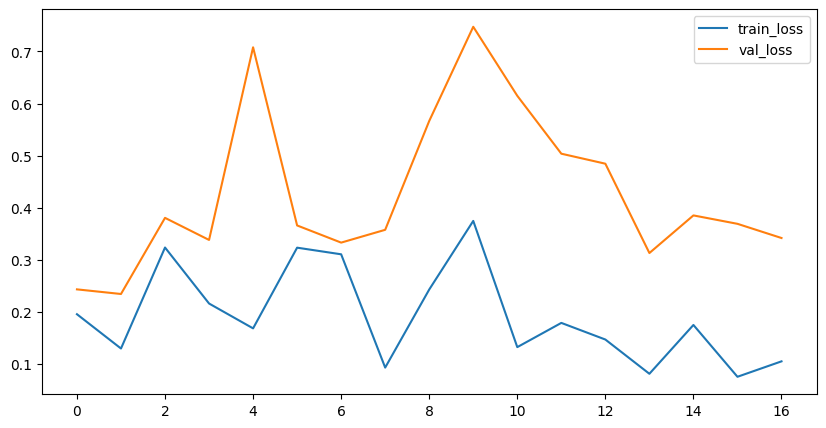

In [21]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device)

In [ ]:
# print state of model
model.state_dict()

In [22]:
load_checkpoint("hard_contrast_cnn_siamese_best_model.pth", model, optimizer)

<ipython-input-9-90b34ad426dc>:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


(SiameseNetwork(
   (backbone): EfficientNet(
     (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
     (bn1): BatchNormAct2d(
       24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
       (drop): Identity()
       (act): SiLU(inplace=True)
     )
     (blocks): Sequential(
       (0): Sequential(
         (0): ConvBnAct(
           (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn1): BatchNormAct2d(
             24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
             (drop): Identity()
             (act): SiLU(inplace=True)
           )
           (aa): Identity()
           (drop_path): Identity()
         )
         (1): ConvBnAct(
           (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn1): BatchNormAct2d(
             24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
             (drop): I

In [23]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances, recall_score, precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


def generate_embeddings(model, loader, device):
    """
    Generate embeddings and labels for all samples in the validation loader.

    Args:
        model (torch.nn.Module): Trained Siamese network.
        loader (torch.utils.data.DataLoader): Validation data loader.
        device (torch.device): Device to use for computation.

    Returns:
        embeddings (numpy.ndarray): Generated embeddings for all samples.
        labels (numpy.ndarray): Corresponding class labels.
    """
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for images, targets in loader:  # Assuming loader returns (image, label) tuples
            images = images.to(device)
            outputs = model(images)
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)

    return embeddings, labels

def compute_recall_at_k(embeddings, labels, k=5):
    """
    Compute Recall@K for the generated embeddings.

    Args:
        embeddings (numpy.ndarray): Embedding vectors.
        labels (numpy.ndarray): Corresponding class labels.
        k (int): Number of nearest neighbors to consider.

    Returns:
        recall (float): Recall@K value.
    """
    distances = pairwise_distances(embeddings, metric="euclidean")
    recall_at_k = []

    for i in range(len(labels)):
        # Get indices of the K nearest neighbors (excluding itself)
        neighbors = np.argsort(distances[i])[1:k+1]
        # Check if any neighbor has the same label
        recall_at_k.append(any(labels[i] == labels[neighbor] for neighbor in neighbors))

    return np.mean(recall_at_k)

def compute_map(embeddings, labels):
    """
    Compute Mean Average Precision (mAP) for the embeddings.

    Args:
        embeddings (numpy.ndarray): Embedding vectors.
        labels (numpy.ndarray): Corresponding class labels.

    Returns:
        mAP (float): Mean Average Precision score.
    """
    distances = pairwise_distances(embeddings, metric="euclidean")
    average_precisions = []

    for i in range(len(labels)):
        # Get sorted indices based on distances
        neighbors = np.argsort(distances[i])
        relevant = 0
        precision_sum = 0.0

        for rank, neighbor in enumerate(neighbors[1:], start=1):  # Skip self-comparison
            if labels[i] == labels[neighbor]:
                relevant += 1
                precision_sum += relevant / rank

        if relevant > 0:
            average_precisions.append(precision_sum / relevant)

    return np.mean(average_precisions)



def visualize_embeddings(embeddings, labels):
    """
    Visualize embeddings using t-SNE.

    Args:
        embeddings (numpy.ndarray): Embedding vectors.
        labels (numpy.ndarray): Corresponding class labels.
    """
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="tab10", s=5
    )
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Embeddings")
    plt.show()

def evaluate_model(model, loader, device, k=5):
    """
    Evaluate the Siamese network.

    Args:
        model (torch.nn.Module): Trained Siamese network.
        loader (torch.utils.data.DataLoader): Validation data loader.
        device (torch.device): Device for computation.
        k (int): Number of neighbors for Recall@K.

    Returns:
        metrics (dict): Evaluation metrics including Recall@K and mAP.
    """
    embeddings, labels = generate_embeddings(model, loader, device)

    # Compute metrics
    recall = compute_recall_at_k(embeddings, labels, k)
    map_score = compute_map(embeddings, labels)

    print(f"Recall@{k}: {recall:.4f}")
    print(f"Mean Average Precision (mAP): {map_score:.4f}")

    # Visualize embeddings
    visualize_embeddings(embeddings, labels)

    return {"Recall@K": recall, "mAP": map_score}

In [ ]:
model = SiameseNetwork(
    backbone_name="tf_efficientnetv2_m_in21k",
).to(device)
load_checkpoint("cnn_siamese_best_model.pth", model, optimizer)

In [24]:
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
test_dataset = datasets.ImageFolder(root='data/test', transform=val_transform)

In [26]:
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=8, pin_memory=True)

Recall@5: 0.8082
Mean Average Precision (mAP): 0.3455


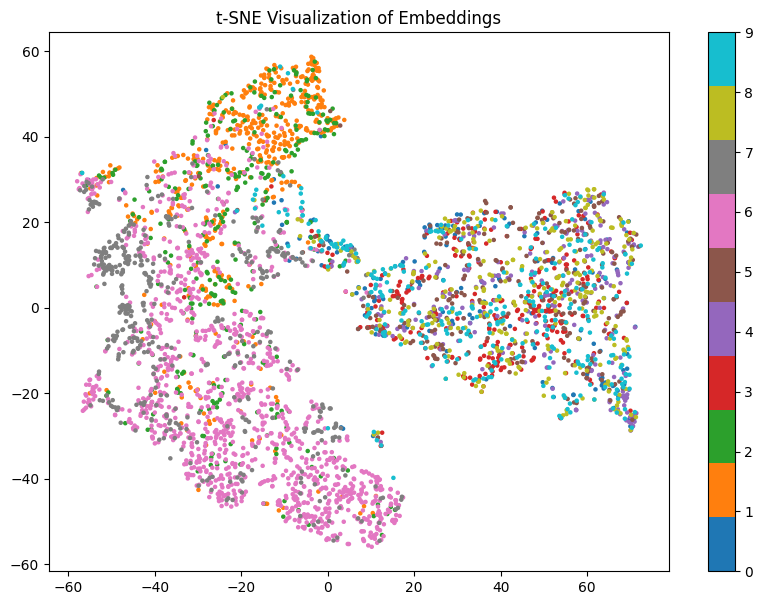

In [27]:
metrics = evaluate_model(model, test_loader, device, k=5)

In [ ]:
print(metrics)

{'Recall@K': 0.8311720088084169, 'mAP': 0.38337894178194887}


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

Exception ignored in: <function _ConnectionBase.__del__ at 0x798f78322710>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
